In this homework, the goal is to analyze a single-cell RNA-seq dataset derived from lung cancer patients. The data used in this homework is a subset of the data presented [here](https://pubmed.ncbi.nlm.nih.gov/34653364/).

Download the following data into the `data` directory
1. RU675_RU682.h5ad available at [link](https://drive.google.com/file/d/1jvuL2zYNpmdX4OH6-mKT9OZuEkOuz74-/view?usp=share_link)
2. RU675_filtered.tar.gz at [link](https://drive.google.com/file/d/11yQoiVrOcFuvtlJ06bNErlOTCsnnlWM5/view?usp=share_link). Untar this file after downloading.

The first part of the homework will use the data from one patient available at `data/RU675_filtered`. 
The batch correction section of the algorithm will make use of the data in the preprocessed anndata object `data/RU675_RU682.h5ad`. 

The homework is a series of empty code-cells which you will need to update to generate the necessary outputs. The expected outputs are shown in many instances. Note that the umaps and clusters you will  identify might be slightly different to the expected outputs due to random seeds used by `scanpy`.

The conda environment that you built for the class should work for the Homework too.

# Imports

In [1]:
import numpy as np 
import pandas as pd
import scanpy as sc

In [2]:
# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline


# Load data and QC - 5 points

Data is available to dowload at


Unlike the lecture, the data is not in the `h5` format, but exported as text

In [4]:
# The data can be loaded using the following
os.getcwd()
ad = sc.read_10x_mtx('/workspaces/tfcb_2022/lectures/lecture18/data/RU675_filtered/')

In [5]:
# Compute QC metrics including the percent of mitochondrial fractions in the cells

# Set Mitochondrial genes
ad.var['mt'] = ad.var_names.str.startswith('MT-')

# Compute QC metrics
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'], 
                           inplace=True, log1p=False)

In [6]:
# Print out the ad results 
ad

AnnData object with n_obs × n_vars = 3666 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Filter cells - 10 points

## Based on molecule counts 

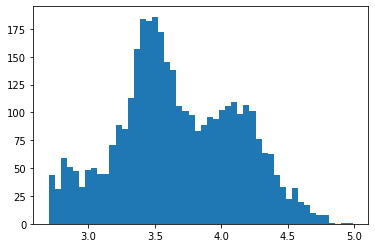

In [7]:
# Plot the histogram log10 molecule counts per cell. 
# Hint: Use ad.obs['total_counts']
plt.hist(np.log10(ad.obs['total_counts']), 50);

In [8]:
# Remove cells with fewer than 1000 molecules and greater than 32000 molecules
use_cells = ad.obs_names[(ad.obs['total_counts'] > 1000) & (ad.obs['total_counts'] < 32000)]
ad = ad[use_cells, :]

In [9]:
# How many cells are retained after this filter?
ad

View of AnnData object with n_obs × n_vars = 3268 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Mitochondrial fraction 

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


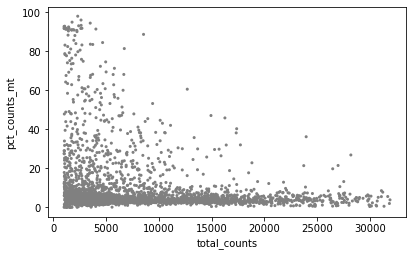

In [10]:
# Make a scatter plot with total_counts on the x-axis and pct_counts_mt on the y-axis
sc.pl.scatter(ad, x = 'total_counts', y = 'pct_counts_mt')

In [11]:
# How many cells do you find with a mitochondrial percentage > 20%?

mito_cells = ad.obs_names[(ad.obs['pct_counts_mt'] > 20)]
mito_cells

Index(['TTTATGCGTAAGTGTA', 'TTTATGCGTGTCGCTG', 'TTTATGCCATCTGGTA',
       'TTTGGTTAGAATTCCC', 'TTTGCGCTCTACCTGC', 'TTTCCTCAGGATGGAA',
       'TTATGCTTCTCTGAGA', 'TTATGCTCAAGCCCAC', 'TTAGTTCGTGCGAAAC',
       'TTAGTTCCACATGACT',
       ...
       'CCTATTATCGGCTACG', 'CCTAGCTTCCAATGGT', 'CCTACACTCCCAAGTA',
       'CCATTCGCATATACCG', 'CCACTACTCACCAGGC', 'CCACTACAGCAGCCTC',
       'CCGTTCATCAACACGT', 'CCGTGGATCTTTAGGG', 'CCGGTAGAGTAGTGCG',
       'CCCAATCAGGGCATGT'],
      dtype='object', length=343)

In [12]:
# Remove cells with mitochondrial percentage > 20%
mito_less_cells = ad.obs_names[(ad.obs['pct_counts_mt'] < 20)]
mfad = ad[mito_less_cells, :]
mfad

View of AnnData object with n_obs × n_vars = 2925 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Additional information

The following methods take a more principled approach to identify cell-containing barcodes
* [EmptyDrops](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y)
* [SoupX](https://academic.oup.com/gigascience/article/9/12/giaa151/6049831)
* [DecontX](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1950-6)


# Preprocess the data - 10 points

In [13]:
# Normalize the cells to correct for molecule count and perform log transformation
sc.pp.normalize_total(mfad)
sc.pp.log1p(mfad)

/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
mfad

AnnData object with n_obs × n_vars = 2925 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

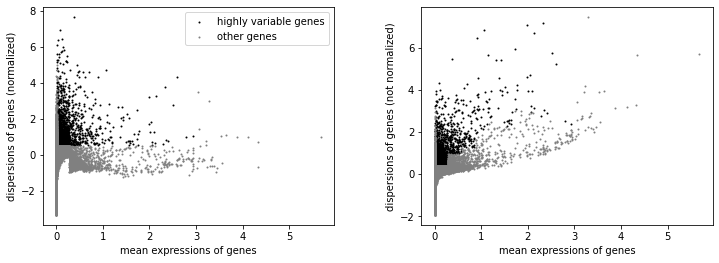

In [15]:
# Select highly variable genes and visaluze them
sc.pp.highly_variable_genes(mfad)
mfad
sc.pl.highly_variable_genes(mfad)

In [16]:
# How many genes were chosen to be highly variable?
sum(mfad.var['highly_variable'] == True)


3483

# Analysis - 45 points 

In [17]:
# Perform PCA on the normalized data [PCA + plot - 5points ]
sc.pp.pca(mfad)

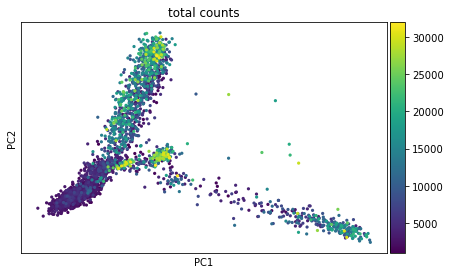

In [18]:
# Plot the first two PC components colored by total counts
sc.pl.scatter(mfad, basis='pca', color=['total_counts'])

In [19]:
# Compute neighborhoods, clustering and umaps  - 
# Computing and plotting: 5 points 
sc.pp.neighbors(mfad) # neighbors
sc.tl.leiden(mfad) # clusters
sc.tl.umap(mfad) # umap

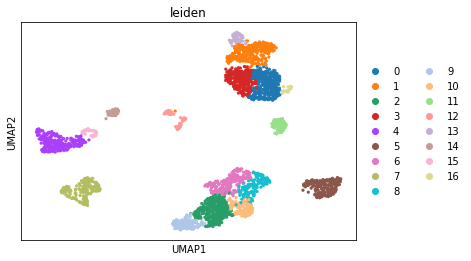

In [20]:
# Plot the umap colored leiden clusters 
sc.pl.umap(mfad, color=['leiden'])

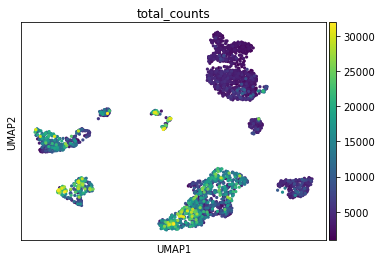

In [21]:
# Plot the umap colored by total counts 
sc.pl.umap(mfad, color=['total_counts'])

Here are the markers for different cell-types
* T-cells: CD3D
* B-cells: CD19
* Monocytes: FCER1G
* MAST cells: TPSB2
* Plasma cells: MZB1
* Epithelial: EPCAM
* Fibroblasts: CALD1
* Endothelial cells: SPARCL1


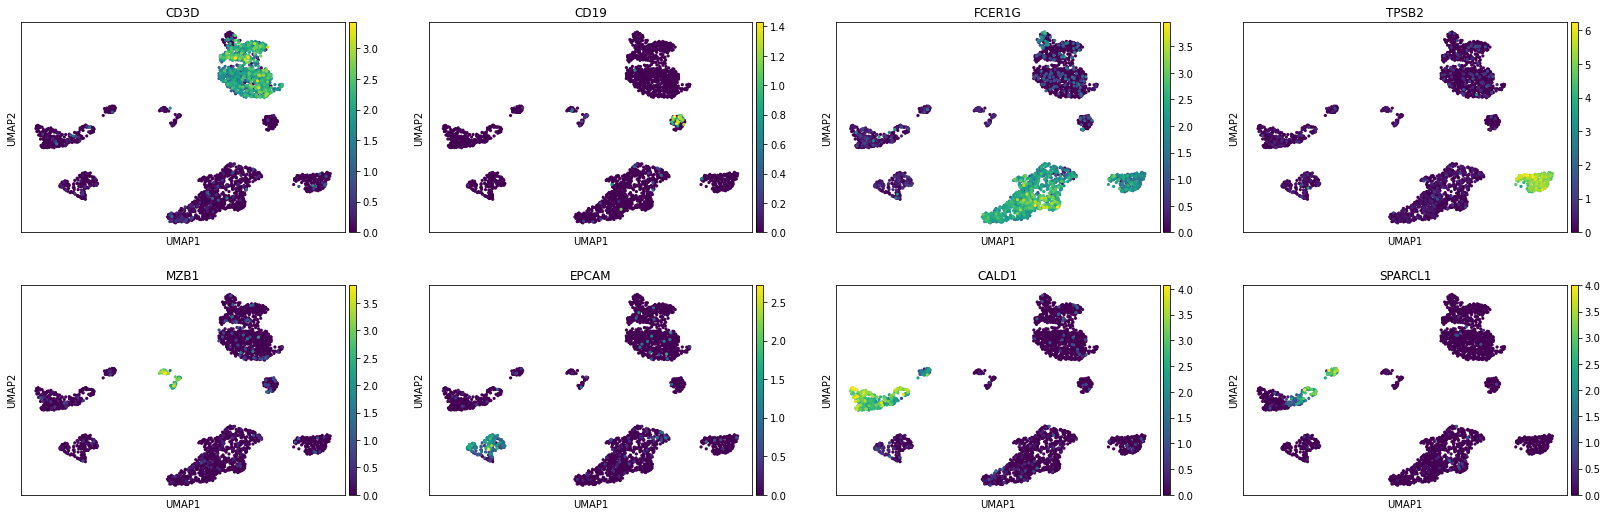

In [22]:
# Plot the expression of marker genes on umap - 5 points
marker_genes = ['CD3D',
'CD19', 
'FCER1G',
'TPSB2',
'MZB1',
'EPCAM',
'CALD1',
'SPARCL1']

sc.pl.umap(mfad, color=['CD3D',
'CD19', 
'FCER1G',
'TPSB2',
'MZB1',
'EPCAM',
'CALD1',
'SPARCL1'])

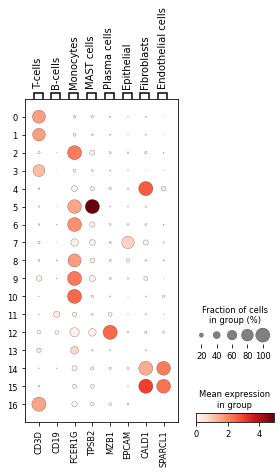

In [23]:
# Make a dotplot of these markers for each cluster - 5 points
marker_genes_dict = {"T-cells": ["CD3D"],
"B-cells": ["CD19"],
"Monocytes": ["FCER1G"],
"MAST cells": ["TPSB2"],
"Plasma cells": ["MZB1"],
"Epithelial": ["EPCAM"],
"Fibroblasts": ["CALD1"],
"Endothelial cells": ["SPARCL1"]}

sc.pl.dotplot(mfad, marker_genes_dict, groupby='leiden');

In [24]:
# Use the visualization and dotplots to annotate each cluster with the cell-type - 
# A pandas series can be used for generating the mapping
# Two example of how this can be done is mentioned in the cell
# 20 points for cell type annotation and plotting
ct_annotations = pd.Series(dtype=object)
ct_annotations['0'] = 'T-cells'
ct_annotations['1'] = 'T-cells'
ct_annotations['2'] = 'Monocytes'
ct_annotations['3'] = 'T-cells'
ct_annotations['4'] = 'Fibroblast'
ct_annotations['5'] = 'MAST cells'
ct_annotations['6'] = 'Monocytes'
ct_annotations['7'] = 'Epithelial'
ct_annotations['8'] = 'Monocytes'
ct_annotations['9'] = 'Monocytes'
ct_annotations['10'] = 'Monocytes'
ct_annotations['11'] = 'B-cells'
ct_annotations['12'] = 'Plasma cells'
ct_annotations['13'] = 'T-cells' # or Mono
ct_annotations['14'] = 'Endothelial cells'
ct_annotations['15'] = 'Fibroblast'
ct_annotations['16'] = 'T-cells'


In [25]:
# Assign cell-types to cells. Note this code will work only if all clusters are annotated
mfad.obs['celltype'] = ct_annotations[mfad.obs['leiden']].values

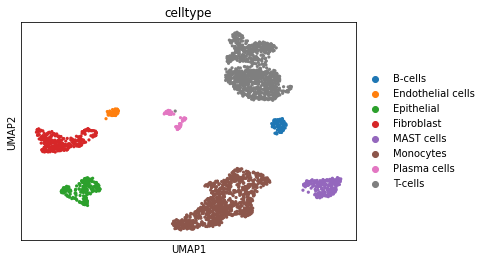

In [27]:
# Plot cell types on umap
sc.pl.umap(mfad, color=['celltype'])

## Extra credit (15 points) 
Write a procedure to automatically determine the cluster to cell-type annotations using marker gene expression. and cluster similarliy. 

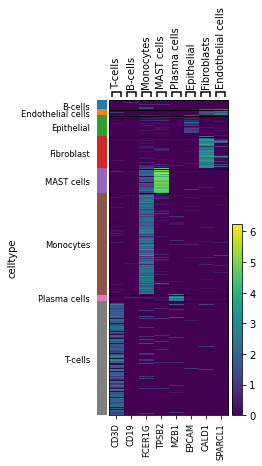

In [42]:
# Plot heatmap of marker genes per cell - 5 points

sc.pl.heatmap(mfad, marker_genes_dict, groupby='celltype')


It is rather amazing that we can derive such heterogeneity from a single tumor biopsy !

## Additional information

There is a huge array of literature looking at different normalization techniques. Some interesting methods are 
* [SCtransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)
* [SCNorm](https://www.nature.com/articles/nmeth.4263)
* [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)

There are a number of deep-learning autencoder methods that start with count matrices and provide representations for visualization, clustering and other downstream analyses
* [scVI](https://www.google.com/search?client=safari&rls=en&q=scvi+single+cell&ie=UTF-8&oe=UTF-8)
* [DCA](https://www.nature.com/articles/s41467-018-07931-2)
* [Saucie](https://www.nature.com/articles/s41592-019-0576-7)


# Analysis of a subset - 20 points

Often times with single-cell data analysis, we will need to re-analyze a compartment to understand the structure better. In this section, the goal is to zoom into the epithelial compartment. 

In [47]:
# Create a new anndata object called "sub_ad" with only T-cells
sub_ad = mfad[mfad.obs['celltype'] == 'T-cells', :]
sub_ad

View of AnnData object with n_obs × n_vars = 1059 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<b> Questions - 5 points</b>
* Should the data be normalized again ?
No
* Why or why not ? 
The data is already normalized before subsetting. The normalization "is performed by dividing the counts by total molecule counts for each cell" so the data is normalized using the total molecule counts per individual cell, and subsetting the cells should not affect that transformation.

In [48]:
# Recompute the highly variable genes for this subset of cells
sc.pp.highly_variable_genes(sub_ad)

# Question: Why is this necessary
# this is necessary because high variability is relative so in this subset, we have a new standard for high variability 


/opt/conda/envs/tfcb2022_rna/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


In [49]:
# Perform PCA and compute clusters and umap
sc.pp.pca(sub_ad)

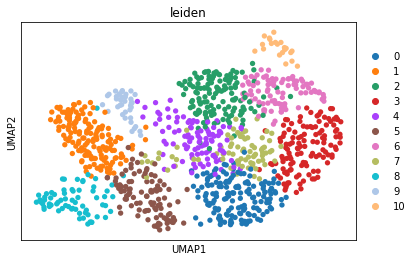

In [51]:
sc.pp.neighbors(sub_ad)
sc.tl.leiden(sub_ad)
sc.tl.umap(sub_ad)

sc.pl.umap(sub_ad, color=['leiden'])


In [52]:
# Identify differentially expressed genes per cluster
sc.tl.rank_genes_groups(sub_ad, groupby='leiden')

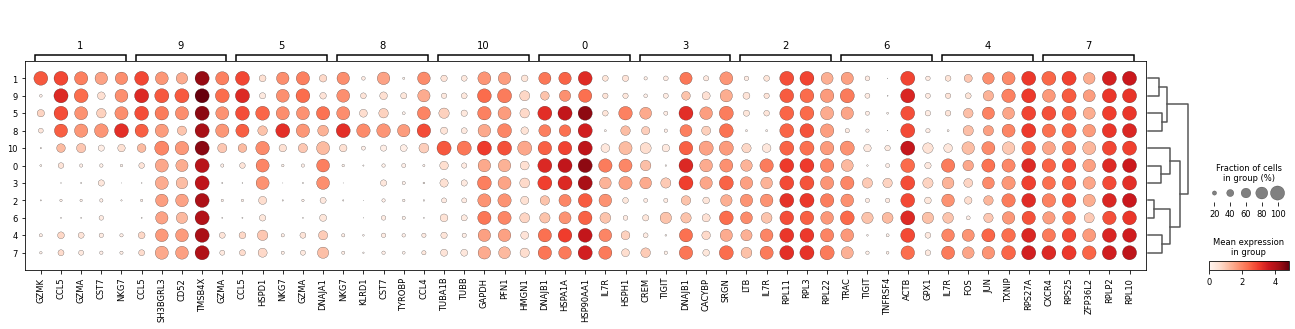

In [53]:
# Plot the top 5 genes per cluster as a dotplot
sc.tl.dendrogram(sub_ad, 'leiden') # This command is necessary since the clusters were re-computed

sc.pl.rank_genes_groups_dotplot(sub_ad, n_genes=5)

# the reason this looks a little different is because I have 1 extra cluster but overall it is pretty close

# Batch correction (Extra credit) - 10 points

In this section, the goal is to batch correct data from two normal samples. 

In [55]:
# Load the anndata 
norm_ad = sc.read('/workspaces/tfcb_2022/lectures/lecture18/data/RU675_RU682.h5ad')

In [56]:
# The preprocessing and analysis steps are already done in this anndata object
norm_ad

AnnData object with n_obs × n_vars = 6620 × 17287
    obs: 'sample', 'batch', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

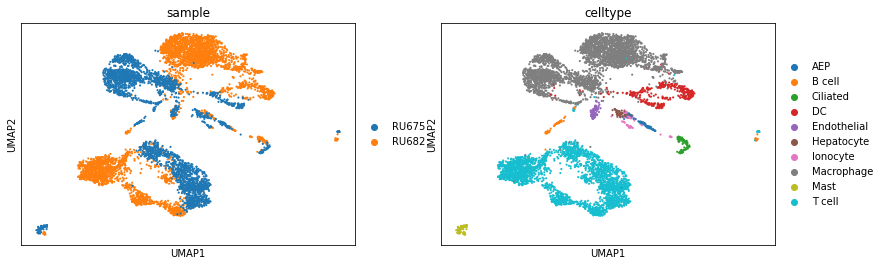

In [57]:
# Visualize the sample and cell type on the already computed umaps
sc.pl.umap(norm_ad, color=['sample', 'celltype'])

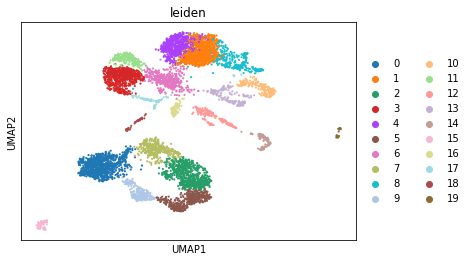

In [58]:
# Visualize the clusters
sc.pl.umap(norm_ad, color=['leiden'])

In [59]:
# Save the pre-batch correction as leiden_pre_correction
norm_ad.obs['leiden_pre_correction'] = norm_ad.obs['leiden']

In [61]:
# Apply batch correction using Harmony and re-computed UMAPs and clusters 
sc.external.pp.harmony_integrate(norm_ad, key='sample')

2022-12-14 20:26:05,225 - harmonypy - INFO - Iteration 1 of 10
2022-12-14 20:26:36,024 - harmonypy - INFO - Iteration 2 of 10
2022-12-14 20:27:07,236 - harmonypy - INFO - Iteration 3 of 10
2022-12-14 20:27:39,636 - harmonypy - INFO - Iteration 4 of 10
2022-12-14 20:28:11,962 - harmonypy - INFO - Iteration 5 of 10
2022-12-14 20:28:39,141 - harmonypy - INFO - Converged after 5 iterations


In [63]:
# Visualize the batch corrected-clusters and celltypes on batch-corrected umaps
sc.pp.neighbors(norm_ad, use_rep='X_pca_harmony')
# UMAP and leiden use results from the neighborhood computation. Therefore we dont need to specify harmony
sc.tl.umap(norm_ad)
sc.tl.leiden(norm_ad)



KeyboardInterrupt: 

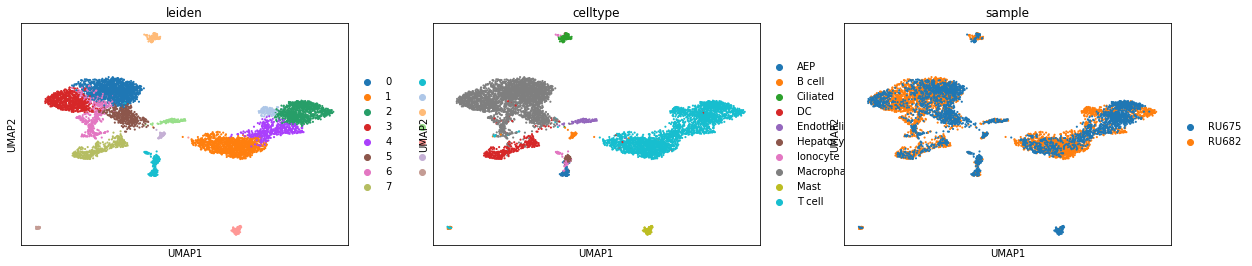

In [64]:
sc.pl.umap(norm_ad, color=['leiden', 'celltype', 'sample'])

<b>Question</b>: What are you observations? 

My observations are that when you batch correct, there is way less variability in the sample and the cell types. The cluster more closely plotted. In the sample umap, the two clusters are separated by something other than just sample (overlapping blue and orange) whereas in the pre- corrected data, the samples cluster separately.

## Extra credit - 10 points

In [41]:
# Goal - identify how the pre-batch correction clusters are reassigned after batch correction
# Compute a matrix where each row is the batch corrected cluster and each column is a pre-corrected cluster
# Each entry of the matrix should represent the number of cells in 
# each (pre-batch correction and post-correction) clusters

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,825,0,0,70,0,0,0,0,0,0,0,0,0,0
1,841,0,1,9,0,17,7,0,0,0,0,0,0,0,0
2,0,9,374,0,338,0,0,0,0,2,0,0,0,0,0
3,545,0,0,6,0,1,70,0,0,0,0,0,0,0,0
4,10,0,0,549,0,17,0,0,0,0,0,0,0,0,0
5,0,0,467,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0,3,0,395,0,2,1,0,0,0,0,0,0
7,0,329,0,0,20,1,0,0,0,0,0,0,0,0,0
8,6,0,0,0,0,3,277,0,0,0,0,0,0,0,0
9,0,0,49,0,42,0,0,0,0,127,0,0,0,0,0


<AxesSubplot:>

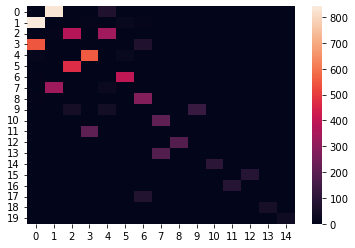

In [42]:
# Plot the count matrix as a heatmap 


In [43]:
# Normalize such that each row sums to 1 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.921788,0.000000,0.000000,0.078212,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.961143,0.000000,0.001143,0.010286,0.000000,0.019429,0.008000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.012448,0.517289,0.000000,0.467497,0.000000,0.000000,0.000000,0.000000,0.002766,0.0,0.0,0.0,0.000000,0.0
3,0.876206,0.000000,0.000000,0.009646,0.000000,0.001608,0.112540,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.017361,0.000000,0.000000,0.953125,0.000000,0.029514,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
6,0.014742,0.000000,0.000000,0.007371,0.000000,0.970516,0.000000,0.004914,0.002457,0.000000,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.940000,0.000000,0.000000,0.057143,0.002857,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
8,0.020979,0.000000,0.000000,0.000000,0.000000,0.010490,0.968531,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.224771,0.000000,0.192661,0.000000,0.000000,0.000000,0.000000,0.582569,0.0,0.0,0.0,0.000000,0.0


<AxesSubplot:>

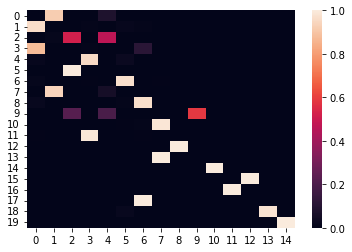

In [44]:
# Plot the count matrix as a heatmap 
